### This notebook preps the data for the Spark_Recommender_Prototype
    1. Remove non red or white wine product keys from the product data
    2. Filter out customers with less than 5 red or white wine purchases hashs
    3. Filter out customersh with no subsequent purchases 
    4. Filter out purchases hashes with 10 or more purchases (bulk purchases)
    5. Replace n_purchases with relative rating for each user 
    6. Transform floating point ratings into categorical values 
   

### Periodic Data Prep
This data prep should be performed on the msster data sets perodically, on batches of new data. For instance, after having 10's of new, or existing customers, make their 5th purchase of a wine that they have not purchaused previous. You'll see that user's with less than 5 purchases of distnct wines are filtered out of the purchase data set and never make it to the recommender.

In [1]:
reset -f -s

In [2]:
whos

Interactive namespace is empty.


In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import cPickle
from time import time
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pylab
% matplotlib inline

In [6]:
# needs access to wifi
# import plotly.graph_objs as go
# import plotly.plotly as py

#### Load Data

In [4]:
wine_path = "/Users/Alexander/Wine_Recommender/data/Products.txt"
purchases_path = "/Users/Alexander/Wine_Recommender/data/Purchases.txt"

In [5]:
def load_data(wine_path, purchases_path):
    products_df = pd.read_csv(wine_path, sep = '\t')
    purchase_df = pd.read_csv(purchases_path, sep = '\t')
    return products_df, purchase_df

In [6]:
products_df, purchase_df = load_data(wine_path, purchases_path)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
purchase_df.head()

,CustomerHash,PurchaseHash,ProductKey,Date,Units
0,F1923160355C00D4D1E7801F74132540,C60D8C98A7328EF5A1F5090D6A29DB7F,222650,2015-06-18,1
1,D3BE5BC2AA8796FCD402023CD6E5A6AC,C9F6085954D5D36615EE0BA44BEB0A2A,95350,2009-08-04,1
2,00D7447BAB0443738F81C3660F478357,18B773B0D5568E406CBB946F628C1DC6,38706,2007-12-10,1
3,F3548BD72E0F97ECBDA95918DE2743AD,96FEEC28AB4F35342DE08987D39406FC,333116,2012-03-16,2
4,9A260E4A83A112AA06F06A11DBF98BBD,07879D41A42AD75F020E3DA70D698ACC,221136,2007-05-08,1


In [9]:
units_purchased = purchase_df.groupby(["CustomerHash"])["Units"].sum()

In [21]:
# user with the most purchases 
units_purchased.max()

20375

In [25]:
# total number of purchases over the span of about 10 years 
purchase_df.Units.count()

6628100

In [22]:
# total number of unique customers over the span of about 10 years 
len(purchase_df.CustomerHash.unique())

851663

In [23]:
# about half of all customers have purchased 3 or less wines in 10 years
len(units_purchased[units_purchased <= 3])

421666

In [24]:
# about a forth of all customers have purchased 1 wine in 10 years 
len(units_purchased[units_purchased == 1])

216017

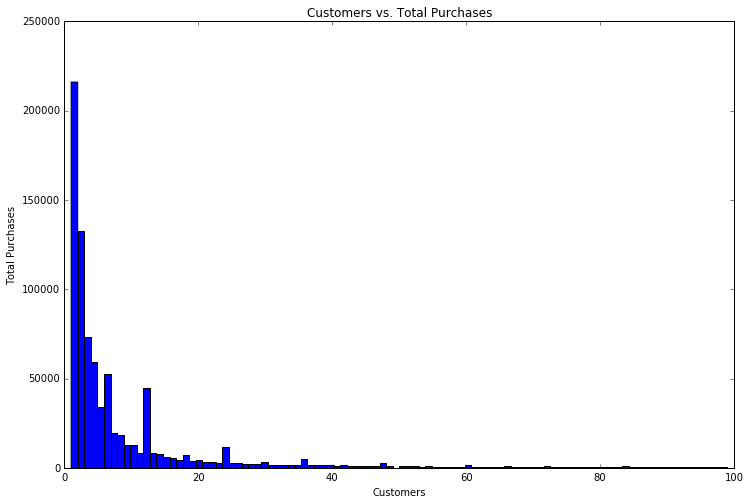

In [20]:
plt.figure(figsize = (12, 8));
plt.title("Customers vs. Total Purchases")
plt.xlabel('Customers')
plt.ylabel("Total Purchases")
plt.hist(units_purchased[units_purchased < 100], bins = 100);
#plt.savefig("/Users/Alexander/Wine_Recommender/Data/customersh_vs_total_purchases.png")

### Remove non red or white wine product keys from the product data
    The motivations for purchasing wines are different from the motivations for purchasing 
    whisky or champaign. 

In [14]:
def remove_non_wine_products(products_df):
    '''Removes products from the products data that are not red or white wines'''
    
    # isolate wines from other drinks (Product Types)
    white_wine_mask = products_df.Class == 'White Wines'
    red_wine_mask = products_df.Class == 'Red Wines'
    
    white_wine_df = products_df[white_wine_mask]
    red_wine_df = products_df[red_wine_mask]
    
    # build wine df
    wine_df = red_wine_df.append(white_wine_df)
    wine_cols = [u'ProductKey', u'ProductId', u'Appellation', u'Varietal', u'Vineyard', 'Class']
    wine_df = wine_df[wine_cols]
    
    return wine_df

In [15]:
wine_df = remove_non_wine_products(products_df)

In [16]:
# exclusively red and white wine product keys
wine_df.head()

,ProductKey,ProductId,Appellation,Varietal,Vineyard,Class
0,2,127554,Napa Valley,Cabernet Sauvignon,Turnbull,Red Wines
1,3,133070,Napa Valley,Cabernet Sauvignon,Turnbull,Red Wines
2,4,114037,Napa Valley,Cabernet Sauvignon,Turnbull,Red Wines
5,7,109508,Napa Valley,Other Red Blends,Turnbull,Red Wines
6,8,110277,Napa Valley,Merlot,Turnbull,Red Wines


### Save wine_df to file

In [17]:
path = "/Users/Alexander/Wine_Recommender/data/wine_products.pkl"

In [18]:
wine_df.to_pickle(path)

In [19]:
np.unique(wine_df.Class.values)

array(['Red Wines', 'White Wines'], dtype=object)

In [20]:
wine_df.shape[0]

364456

### Filter out customers with less than 5 red or white wine purchases
    In order to detect latent features (wine preferences of users) there needs to be enough 
    purchase data present in order for patterns to emerge. 

In [21]:
def filter_out_users_with_less_than_5_purchases(purchase_df, wine_df):
    '''Remove users with less than 5 red or white purchases of distinct wines 
       Input: purchase_df, dataframe
       Output: userTags_5_or_more_distinct_wine_purchases, list'''
    
    # append wine class column for filtering (i.e. red wines, white wines)
    class_purchase_df = purchase_df.merge(wine_df[["ProductKey","Class"]], how="left", on="ProductKey")
    
    # isolate red and white wine purchases 
    red_purchases_df = class_purchase_df[class_purchase_df.Class == "Red Wines"]
    white_purchases_df = class_purchase_df[class_purchase_df.Class == "White Wines"]
    
    # combine wine types into single purchase df
    wine_purchase_df = red_purchases_df.append(white_purchases_df)
    
    # get tags of unqiue users
    unique_user_tags = wine_purchase_df.CustomerHash.unique()
    
    # group customer tags and wine_ids by count of wine_ids
    distinct_wine_purchases = wine_purchase_df.groupby(["CustomerHash"])["ProductKey"].count()
    
    # filter out users with less than 5 purchases of distinct wines
    # check: if user has sum >= 5, then keep user, else drop user
    userTags_5_or_more_distinct_wine_purchases = \
    [user_tag for user_tag in unique_user_tags if distinct_wine_purchases[user_tag] >= 5]
    
    # Sanity check -- number of users should dramatically decrease
    n_total_unique_tags = len(unique_user_tags)
    n_new_tags = len(userTags_5_or_more_distinct_wine_purchases)
    
    print "Pre-filter"
    print "Total users {}\n".format(n_total_unique_tags)
    print "Post-filter"
    print "Total users {}\n".format(n_new_tags)
    print "Retained {:.3} percent of users".format(float(n_new_tags)/ float(n_total_unique_tags) * 100)
    
    return userTags_5_or_more_distinct_wine_purchases, wine_purchase_df

In [22]:
start = time()
userTags_5_or_more_distinct_wine_purchases, wine_purchase_df = \
filter_out_users_with_less_than_5_purchases(purchase_df, wine_df)
end = time()
print "Time Elapsed = {:3}".format(end - start)

Pre-filter
Total users 719800

Post-filter
Total users 225056

Retained 31.3 percent of users
Time Elapsed = 17.6809420586


### Filter out Customers with no subsequent purchases
    The goal of the recommender is to model the purchasing behavior of recurring users. 
    Users who visit the site once and never return provide no predictive signal, only noise. 

In [23]:
def filter_customers_with_no_subsequent_purchases(wine_purchase_df, purchase_df, userTags_5_or_more_distinct_wine_purchases):
    '''Removes customers that don't have at least 1 subsequent purchase '''
    distinct_purchase_hash = wine_purchase_df.groupby(["CustomerHash"])["Date"].unique()
    
    # check: if user has sum > 1, then keep user, else drop user
    userTags_has_subsequent_purchases = \
    [user_tag for user_tag in userTags_5_or_more_distinct_wine_purchases if len(distinct_purchase_hash[user_tag]) > 1]
    
    new_purchase_df = wine_purchase_df[wine_purchase_df.CustomerHash.isin(userTags_has_subsequent_purchases)]
    
    # Sanity check - Before filtering out users 
    n_total_purchases = purchase_df.shape[0]
    n_total_unique_users = len(purchase_df.CustomerHash.unique())
    
    print "Pre-filter"
    print "number of purchases {}".format(n_total_purchases)
    print "Unique user {}\n".format(n_total_unique_users)
    
    # Sanity check - After filtering out users 
    n_new_purchases = new_purchase_df.shape[0]
    n_new_unique_users = len(new_purchase_df.CustomerHash.unique())
    
    print "Post-filter"
    print "number of purchases {}".format(n_new_purchases)
    print "Unique user {}\n".format(n_new_unique_users)
    
    print "Retained {:.3} percent of total purchases ".format(float(n_new_unique_users)/  n_total_unique_users * 100)
    print "Retained {:.3} percent of unique users "..format(float(n_new_purchases)/ n_total_purchases * 100)
    
    return new_purchase_df

In [24]:
# the retention numbers at bottom of the cell are actually reveresed
start = time()
new_purchase_df = \
filter_customers_with_no_subsequent_purchases(wine_purchase_df,purchase_df, userTags_5_or_more_distinct_wine_purchases)
end = time()
print "Time Elapsed = {:.3}".format(end - start)

Pre-filter
number of purchases 6628100
Unique user 851663

Post-filter
number of purchases 4561063
Unique user 166563

Retained 68.8 percent of unique users 
Retained 19.6 percent of total purchases 
Time Elapsed = 55.5


### Remove purchases (rows) with more than K purchases 
    K can be adjusted, say, bewteen 10 and 20. 
    Let's start with 10. 
    
    We want to remove the bulk purchases made by wedding and party planers. 
    These bulk purchases of a single type of wine don't reflect any deep wine preferences. 

In [25]:
def remove_bulk_purchases(df, k = 10):
    bulk_mask = df.Units < k
    return new_purchase_df[bulk_mask]

In [26]:
non_bulk_purchase_df = remove_bulk_purchases(new_purchase_df, k = 10)

In [27]:
non_bulk_purchase_df.head()

,CustomerHash,PurchaseHash,ProductKey,Date,Units,Class
0,F1923160355C00D4D1E7801F74132540,C60D8C98A7328EF5A1F5090D6A29DB7F,222650,2015-06-18,1,Red Wines
1,D3BE5BC2AA8796FCD402023CD6E5A6AC,C9F6085954D5D36615EE0BA44BEB0A2A,95350,2009-08-04,1,Red Wines
3,F3548BD72E0F97ECBDA95918DE2743AD,96FEEC28AB4F35342DE08987D39406FC,333116,2012-03-16,2,Red Wines
8,07063348FD923179F3DB718A267AC320,CE4BA5D2980284F59BEA70AB85A7133F,228727,2005-09-17,1,Red Wines
10,431F52162412D5A3D4C83D9EA037F6DA,4A4178935AD6733DEE452ED72E8975DD,212931,2012-10-30,4,Red Wines


In [28]:
non_bulk_purchase_df.Units.describe()

count    4347486.000000
mean           1.828909
std            1.439642
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max            9.000000
Name: Units, dtype: float64

In [29]:
# These users all have 5 or more distinct wine purchases 
# As well as at least 1 subsequent purchase
np.unique(non_bulk_purchase_df.Class.values)

array(['Red Wines', 'White Wines'], dtype=object)

### Convert purchases into pseudo-rating data
    Transform user's number of purchases into a relative rating for each wine
    
For each distinct bottle of wine, 
$$ Rating_{u,w} = \frac{N_{bottles,~ w} - \mu_{(bottle~|~type)~w}}{\sum{N_{(bottles~|~type))~w}}} $$

$N_{bottles}$, number of purchases for wine, w

$\mu_{(bottle~|~type)~w}$, frequency of purchases for this type of wine (i.e. red, white)

$\sum{N_{(bottles~|~type))~w}}$, total number of purchase for this type of wine, for this user

$Rating_{u,w} $, rating of wine $w$ by user $u$


In [30]:
def get_user_stats(new_purchase_df):
    '''Get statistics about the user's purchases by wine type (i.e. red wines, white wines)
       Input: total_class_purchases_by_users, series
       Output: users_data, array'''
    
    # get user hash tags
    n_unique_users = len(new_purchase_df.CustomerHash.values) - 1
    # get total number of purchase for each wine type by each user
    total_class_purchases_by_users = new_purchase_df.groupby(["CustomerHash", "Class"])["Class"].count()
    unique_user_tags = np.unique([ item[0][0] for  item in total_class_purchases_by_users.iteritems()])
    
    users_data = []
    
    print "n_unique_users", n_unique_users
    for i, user_tag in enumerate(unique_user_tags):
        user_purchases = total_class_purchases_by_users[user_tag]
        
        indices = user_purchases.index
        
        if 'Red Wines' in indices and "White Wines" in indices:
            total_red_purchases = user_purchases[0]
            total_white_purchases = user_purchases[1]

        elif 'Red Wines' in indices and "White Wines" not in indices:
            total_red_purchases = user_purchases[0]
            total_white_purchases = 0

        else:
            total_red_purchases = 0
            total_white_purchases = user_purchases[0]
        
        total_purchases = total_red_purchases + total_white_purchases
        freq_red_purchases = total_red_purchases/total_purchases
        freq_white_purchases = total_white_purchases/total_purchases
        
        users_data.append([user_tag, 
                   freq_red_purchases, 
                   freq_white_purchases, 
                   total_red_purchases, 
                   total_white_purchases])
        
        if i % 10000 == 0:
            print i
    user_stats_df = pd.DataFrame(users_data)
    col_names = ["CustomerHash", "freq_red", "freq_white", "total_red", "total_white"]
    user_stats_df.columns = col_names
    return user_stats_df

In [31]:
start = time()
user_stats_df = get_user_stats(non_bulk_purchase_df)
end = time()
print "Time Elapsed = {:.3} minutes".format((end - start)/60)

n_unique_users 4347485
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
Time Elapsed = 2.7 minutes


In [32]:
# Sanity check - non_bulk_purchase_df and user_stats_df must have the same number of unique customer hashs
print user_stats_df.shape[0]
print len(np.unique(non_bulk_purchase_df.CustomerHash.values))

165679
165679


### Save data to file

In [33]:
home = "/Users/Alexander/Wine_Recommender/data/"
new_purchase_df_path = home + "non_bulk_purchase_df.pkl"
user_stats_df_path = home + "user_stats_df.pkl"

In [34]:
new_purchase_df.to_pickle(new_purchase_df_path)

In [35]:
#ser_stats_df.to_pickle(user_stats_df_path)


### Load from file

In [36]:
#new_purchase_df = pd.read_pickle(new_purchase_df_path)

In [37]:
#user_stats_df = pd.read_pickle(user_stats_df_path)

### Transform purchases to floating point ratings

In [38]:
def list_to_dict(user_stats_df):
    user_data_dict = dict()
    user_stats_list = user_stats_df.values.tolist()
    for user_data in user_stats_list:
        user_data_dict[user_data[0]] = user_data[1:]
    return user_data_dict

In [39]:
def map_purchases_to_ratings(non_bulk_purchase_df, user_data_dict):
    results = []
    
    sorted_data = non_bulk_purchase_df.groupby(["CustomerHash", "ProductKey", 'Class'])["Units"].sum()
    
    for item in sorted_data.iteritems():
        user_tag = item[0][0]
        wine_id = item[0][1]
        wine_type = item[0][2]
        N_bottles = item[1]

        user_i_stats = user_data_dict[user_tag]
        red_freq = user_i_stats[0]
        white_freq = user_i_stats[1]
        N_total_red = user_i_stats[2]
        N_total_white = user_i_stats[3]

        if wine_type == "White Wines":
            rating_i = (N_bottles - white_freq) / N_total_white
        elif wine_type == "Red Wines":
            rating_i = (N_bottles - red_freq) / N_total_red
        else:
            print "ERROR: NIETHER RED OR WHITE WINE"
            print item
            break

        results.append([user_tag, wine_id, rating_i])
    return results

In [40]:
user_data_dict = list_to_dict(user_stats_df)

In [41]:
start = time()
results = map_purchases_to_ratings(non_bulk_purchase_df, user_data_dict)
end = time()
print "Time Elapsed = {:.3}".format(end - start)

Time Elapsed = 22.4


In [42]:
# Sanity check unique ids
len(np.unique([result[0] for result in results]))

165679

### Save Ratings to file
    This file contains the ratings that will be directly passed into the Spark recommender.

In [43]:
home = "/Users/Alexander/Wine_Recommender/data/"
pseudo_ratings_path = home + "pseudo_ratings.pkl"

In [44]:
#cPickle.dump(results, open(pseudo_ratings_path, 'w'))

#### Load Ratings data

In [45]:
#results = cPickle.load(open(pseudo_ratings_path, 'r'))

### View Distribution of Floating Point Ratings

In [46]:
results_df = pd.DataFrame(results)

In [47]:
results_df[2].describe()

count    3737914.000000
mean           0.098768
std            0.308420
min            0.000000
25%            0.002778
50%            0.017850
75%            0.074074
max            8.993939
Name: 2, dtype: float64

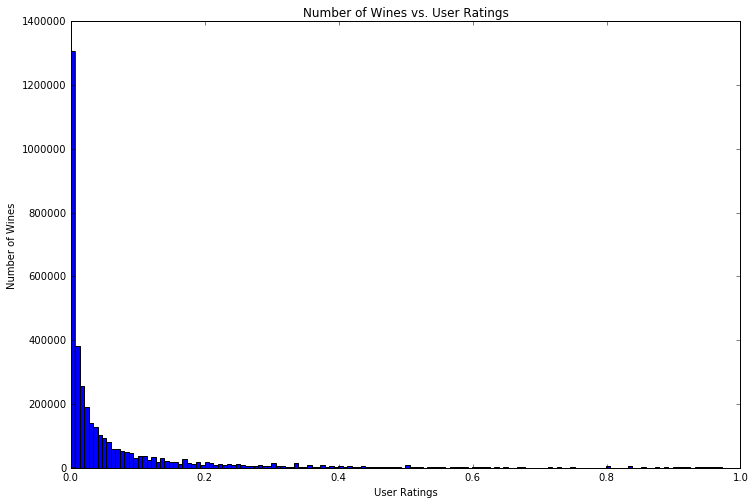

In [48]:
plt.figure(figsize = (12,8));
plt.hist(results_df[2].values[results_df[2].values < 1], bins = 150);
plt.xlim([0,1]);
plt.title("Number of Wines vs. User Ratings");
plt.xlabel("User Ratings");
plt.ylabel("Number of Wines");
plt.savefig("/Users/Alexander/Wine_Recommender/data/continuous_ratings_dist.png")

In [49]:
def get_ranges_for_bins(bin_ranges):
    '''Creates dictionary where keys are discrete rating labels 
       and values are floating point ranges for each labels bin. 
       
       Input: bin_ranges, array of ints
       Output: ranges_dict, defaultdict of lists
       '''
    ranges = []
    ranges_dict = defaultdict(list)
    for i, bin_end in enumerate(bin_ranges):
        if i % 2 == 0:
            temp = bin_end
        else:
            temp_2 = bin_end

        if i > 0 and i % 2 != 0:
            ranges.append([temp, temp_2])

        if i > 0 and i % 2 == 0:
            ranges.append([temp_2, temp])
            
            
    for i, range_ in enumerate(ranges):
        ranges_dict[i].append(range_)
        ranges_dict[i] = ranges_dict[i][0]
    return ranges_dict

In [50]:
def transform_float_ratings_into_categories(ranges_dict, ratings):
    discret_ratings = []
    for rating in ratings:
        for bin_num, bin_range in ranges_dict.iteritems():
            if rating >= bin_range[0] and rating <= bin_range[1]:
                discret_ratings.append(bin_num)
                break
    return np.array(discret_ratings)

### Build Rating Bins 

Iterations through the sorted ratings, add ratings to a bin until a max count is reached, then move on to the next bin, for all B number of bins.

In [51]:
# create B number of bins
n_bins = 10
total_ratings = results_df.shape[0]
bin_count = total_ratings/n_bins

In [52]:
# number of ratings that will be assigned to each bin
bin_count

373791.4

In [53]:
# sort ratings - lowest to largest
sorted_ratings = sorted(results_df[2].values.tolist())

In [54]:
def sort_ratings_into_bins(sorted_ratings, bin_count):
    '''Moves sorted ratings into bins in equal amounts'''
    rating_bins_dict = defaultdict(list)
    rating_cnt = 0
    bin_cnt = 1
    for rating in sorted_ratings:
        if rating_cnt <= bin_count:
            rating_bins_dict[bin_cnt].append(rating)
        else:
            bin_cnt += 1
            rating_cnt = 0
        rating_cnt += 1
    return rating_bins_dict

In [55]:
rating_bins_dict = sort_ratings_into_bins(sorted_ratings, bin_count)

In [57]:
# write function that identifies the ranges for each bin
def get_bin_ranges(rating_bins_dict):
    bin_ranges = defaultdict(list)
    for k, v in rating_bins_dict.iteritems():
        bin_ranges[k].append([np.min(v), np.max(v)])
        bin_ranges[k] = bin_ranges[k][0]
    return bin_ranges

In [58]:
bin_ranges = get_bin_ranges(rating_bins_dict)

In [59]:
bin_ranges

defaultdict(list,
            {1: [0.0, 6.4935064935065111e-05],
             2: [6.4935064935065111e-05, 0.0014925109509679243],
             3: [0.0014925109509679243, 0.0045026881720430104],
             4: [0.0045026881720430104, 0.009486828751709836],
             5: [0.009486828751709836, 0.017850408548082966],
             6: [0.017850408548082966, 0.031490015360983108],
             7: [0.031490015360983108, 0.054545454545454543],
             8: [0.054545454545454543, 0.10039215686274509],
             9: [0.10039215686274509, 0.22222222222222224],
             10: [0.22222222222222224, 8.9939393939393941]})

In [60]:
discret_ratings =  transform_float_ratings_into_categories(bin_ranges, results_df[2].values.tolist())

In [61]:
# Sanity check: get total number of ratings
sum_ = 0
for k, v in Counter(discret_ratings).iteritems():
    sum_ += v

In [62]:
sum_

3737914

In [63]:
# Distribution of ratings into bins should be approximately equal 
Counter(discret_ratings)

Counter({1: 373867,
         2: 373826,
         3: 373718,
         4: 373760,
         5: 373803,
         6: 373846,
         7: 374439,
         8: 373093,
         9: 374955,
         10: 372607})

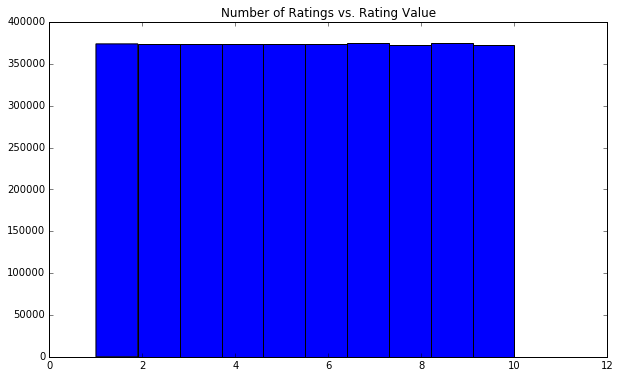

In [67]:
plt.figure(figsize = (10,6));
plt.title('Number of Ratings vs. Rating Value');
plt.hist(discret_ratings, bins =10);

### Move Categorical Ratings to results_df

In [68]:
results_df["Ratings"] = discret_ratings

In [69]:
results_df.columns = ["CustomerHash", "Wine_id", "Wine_Rating", "Ratings"]

In [70]:
results_df = results_df[["CustomerHash", "Wine_id", "Ratings"]]

In [71]:
results_df.head()

,CustomerHash,Wine_id,Ratings
0,00000F7264C27BA6FEA0C837ED6AA0AA,202463,9
1,00000F7264C27BA6FEA0C837ED6AA0AA,202922,6
2,00000F7264C27BA6FEA0C837ED6AA0AA,214365,6
3,00000F7264C27BA6FEA0C837ED6AA0AA,214573,6
4,00000F7264C27BA6FEA0C837ED6AA0AA,219550,6


### Move Spark Ready Wine Ratings Data to File

In [72]:
ratings_data_list = results_df.values.tolist()

In [73]:
spark_ready_data_path = "/Users/Alexander/Wine_Recommender/data/spark_ready_data.pkl"
cPickle.dump(ratings_data_list, open(spark_ready_data_path, 'w') )